## Policy measures analysis
In this notebook multiple policies can be tested, based on a chosen problem formulations. The effects on deaths and costs are summerized at the end of the notebook.

### Imports
Import packages and load model parameters (uncertainties, levers, etc.)

In [19]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [20]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.4.1
2.6.3


In [21]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Scenario,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation


def sum_over(*args):
    return sum(args)

In [22]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

**Problem formulation**
Important cell below, here you can choose the problem formulation number, between 0-5
each problem formulation has its own list of outcomes

In [23]:
used_problem_formulation = 2

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [24]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [25]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

In [26]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage 0', 'A.2_Expected Annual Damage 0', 'A.3_Expected Annual Damage 0', 'A.4_Expected Annual Damage 0', 'A.5_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.2_Expected Annual Damage 1', 'A.3_Expected Annual Damage 1', 'A.4_Expected Annual Damage 1', 'A.5_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.2_Expected Annual Damage 2', 'A.3_Expected Annual Damage 2', 'A.4_Expected Annual Damage 2', 'A.5_Expected Annual Damage 2'), function=<function sum_over at 0x000001A4CFB23C10>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs 0', 'A.2_Dike Investment Costs 0', 'A.3_Dike Investment Costs 0', 'A.4_Dike Investment Costs 0', 'A.5_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.2_Dike Investment Costs 1', 'A.3_Dike Investment Costs 1', 'A.4_Dike Investment Costs 1', 'A.5_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2', 'A.2_Dike Investm

### Policy formulations
In the following cells the wanted policies can be adjusted

In [27]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

In the following policies formulations:
- `RfR` says if the Room for River projects are enabled (projects `0` to `5`). The first number indicated the project, the second (after `RfR`) if in which time step the measure it taken (currently `0` to `2`). The value can be either `0` (not enabled) or `1` (enabled).
- `A.1` to `A.5` are the different dikes. `A.3` is the dike ring around Zutphen. The number after `DikeIncrease` is again the timestep, the value assigned to the thing the heightening in decimeters.
- Early Warning Systems can also be enabled, with `EWS_DaysToThreat`, which specifies the early warning time in days.

See the implementation in problem_formulation.py (starting from line 35) for more details.

In [28]:
# Defining specific policies, in a list of Policy class instances.
policies = [
    Policy(
        "policy 1",
        **dict(get_0_dict(), **{"0_RfR 0": 0, "0_RfR 1": 0, "0_RfR 2": 0, "A.3_DikeIncrease 0": 0})
    ),
    Policy(
        "policy 2",
        **dict(get_0_dict(), **{"0_RfR 0": 0, "0_RfR 1": 0, "0_RfR 2": 0, "A.3_DikeIncrease 0": 5})
    ),
    Policy(
        "policy 3",
        **dict(get_0_dict(), **{"0_RfR 0": 0, "0_RfR 1": 0, "0_RfR 2": 0, "A.3_DikeIncrease 0": 10})
    ),
    Policy(
        "policy 4",
        **dict(get_0_dict(), **{"0_RfR 0": 1, "0_RfR 1": 0, "0_RfR 2": 0, "A.3_DikeIncrease 0": 0})
    ),
    Policy(
        "policy 5",
        **dict(get_0_dict(), **{"0_RfR 0": 0, "0_RfR 1": 1, "0_RfR 2": 0, "A.3_DikeIncrease 0": 0})
    ),
    Policy(
        "policy 6",
        **dict(get_0_dict(), **{"0_RfR 0": 0, "0_RfR 1": 0, "0_RfR 2": 1, "A.3_DikeIncrease 0": 0})
    ),
    Policy(
        "policy 7",
        **dict(get_0_dict(), **{"1_RfR 0": 1, "1_RfR 1": 0, "1_RfR 2": 0, "A.3_DikeIncrease 0": 0})
    ),
    Policy(
        "policy 8",
        **dict(get_0_dict(), **{"1_RfR 0": 0, "1_RfR 1": 1, "1_RfR 2": 0, "A.3_DikeIncrease 0": 0})
    ),
    Policy(
        "policy 9",
        **dict(get_0_dict(), **{"1_RfR 0": 0, "1_RfR 1": 0, "1_RfR 2": 1, "A.3_DikeIncrease 0": 0})
    ),
    Policy(
        "policy 10",
        **dict(get_0_dict(), **{"2_RfR 0": 1, "2_RfR 1": 0, "2_RfR 2": 0, "A.3_DikeIncrease 0": 0})
    ),
    Policy(
        "policy 11",
        **dict(get_0_dict(), **{"2_RfR 0": 1, "2_RfR 1": 0, "2_RfR 2": 0, "A.3_DikeIncrease 0": 0})
    ),
    Policy(
        "policy 12",
        **dict(get_0_dict(), **{"2_RfR 0": 1, "2_RfR 1": 0, "2_RfR 2": 0, "A.3_DikeIncrease 0": 0})
    ),
]

### Run the model (or load the data)
In the next cell the model is ran (if `use_pickle1 = False`) and the new results data is saved, or, if `use_pickle1 = True`, the saved results data is loaded.

In [29]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = True
from ema_workbench import Samplers

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 10000
    with MultiprocessingEvaluator(dike_model, n_processes=7) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, policies=10, uncertainty_sampling=Samplers.LHS)

    # Save results in Pickle file
    with open('data/formulation_results3.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

In [30]:
# Create a dataframe from outcomes, and add the policy column to it
exp, out = results
df = pd.DataFrame(out)
df["policy"] = pd.DataFrame(exp)["policy"]
df

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,policy
0,2.501645e+09,1.729989,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,0.0,0.0,policy 1
1,0.000000e+00,0.000000,0.000000e+00,0.000000,1.539666e+09,3.266719,0.000000e+00,0.000000,0.000000e+00,0.00000,0.0,0.0,policy 1
2,5.818656e+08,0.323293,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,0.0,0.0,policy 1
3,3.261164e+09,1.721956,1.043510e+09,0.683729,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,0.0,0.0,policy 1
4,1.866160e+08,0.137513,1.242352e+07,0.012439,7.130209e+06,0.013678,3.568384e+07,0.017444,2.023429e+08,0.18995,0.0,0.0,policy 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.000000e+00,0.000000,2.478030e+07,0.027325,8.329663e+08,1.622513,0.000000e+00,0.000000,0.000000e+00,0.00000,30700000.0,0.0,policy 12
11996,2.860284e+09,1.763122,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,30700000.0,0.0,policy 12
11997,2.532460e+09,1.756891,0.000000e+00,0.000000,0.000000e+00,0.000000,3.321513e+06,0.001602,0.000000e+00,0.00000,30700000.0,0.0,policy 12
11998,0.000000e+00,0.000000,6.078269e+07,0.070693,0.000000e+00,0.000000,4.475099e+07,0.025756,0.000000e+00,0.00000,30700000.0,0.0,policy 12


In [31]:
out = pd.DataFrame(out)

In [32]:
# set up PRIM

# uncertainties
x_prim = exp[['discount rate 0', 'discount rate 1', 'discount rate 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate', 'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail', 'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax', 'A.5_pfail', 'A.5_Brate']]

numdeaths = out[['A.1_Expected Number of Deaths','A.2_Expected Number of Deaths','A.3_Expected Number of Deaths','A.4_Expected Number of Deaths','A.5_Expected Number of Deaths']]
numdeaths["summed"] = numdeaths.sum(axis = 1, skipna = True)
sumcosts = out[['A.1 Total Costs','A.2 Total Costs','A.3 Total Costs','A.4 Total Costs','A.5 Total Costs']]
sumcosts["summed"] = sumcosts.sum(axis = 1, skipna = True)

# outcomes of interest -> bad outcomes
#y = data < np.percentile(data, 10)

y_prim = ((out['A.3_Expected Number of Deaths'] > 0) | (numdeaths["summed"]>1))

C:\Users\hanna\AppData\Local\Temp\ipykernel_20608\1671250642.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numdeaths["summed"] = numdeaths.sum(axis = 1, skipna = True)
C:\Users\hanna\AppData\Local\Temp\ipykernel_20608\1671250642.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sumcosts["summed"] = sumcosts.sum(axis = 1, skipna = True)


c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


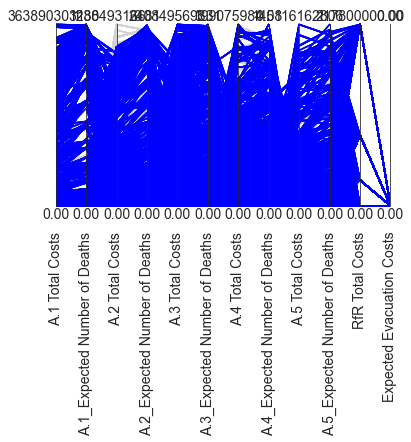

In [34]:
from ema_workbench.analysis import parcoords

# conditional on y
data = pd.DataFrame({k:v[y_prim] for k,v in out.items()})
all_data = pd.DataFrame({k:v for k,v in out.items()})

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)
axes.plot(all_data, color='lightgrey')
axes.plot(data, color='blue')
#axes.invert_axis('max_P')
plt.show()

In [41]:
print(data.idxmin())

A.1 Total Costs                  1
A.1_Expected Number of Deaths    1
A.2 Total Costs                  0
A.2_Expected Number of Deaths    0
A.3 Total Costs                  0
A.3_Expected Number of Deaths    0
A.4 Total Costs                  0
A.4_Expected Number of Deaths    0
A.5 Total Costs                  0
A.5_Expected Number of Deaths    0
RfR Total Costs                  0
Expected Evacuation Costs        0
dtype: int64


In [43]:
print(data.idxmax())
print(sumcosts.idxmax())
print(numdeaths.idxmax())


A.1 Total Costs                   340
A.1_Expected Number of Deaths      18
A.2 Total Costs                  3303
A.2_Expected Number of Deaths    3210
A.3 Total Costs                   367
A.3_Expected Number of Deaths    3799
A.4 Total Costs                  3063
A.4_Expected Number of Deaths    3531
A.5 Total Costs                  3627
A.5_Expected Number of Deaths    1948
RfR Total Costs                  6000
Expected Evacuation Costs           0
dtype: int64
A.1 Total Costs     340
A.2 Total Costs     679
A.3 Total Costs     367
A.4 Total Costs    3063
A.5 Total Costs    3627
summed              116
dtype: int64
A.1_Expected Number of Deaths      18
A.2_Expected Number of Deaths    3649
A.3_Expected Number of Deaths    3799
A.4_Expected Number of Deaths    3531
A.5_Expected Number of Deaths    1948
summed                            900
dtype: int64


In [44]:
selected=x_prim.loc[[0, 1, 116, 900, 3799]]

In [46]:
from ema_workbench import Scenario

scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]


In [65]:
scenarios

[Scenario({'discount rate 0': 4.5, 'discount rate 1': 1.5, 'discount rate 2': 3.5, 'A.0_ID flood wave shape': 75.0, 'A.1_Bmax': 257.3354666385967, 'A.1_pfail': 0.26932421933676914, 'A.1_Brate': 1.5, 'A.2_Bmax': 79.81567483969067, 'A.2_pfail': 0.9106100233951352, 'A.2_Brate': 1.5, 'A.3_Bmax': 85.9937657378821, 'A.3_pfail': 0.5782584135905356, 'A.3_Brate': 10, 'A.4_Bmax': 295.28454815076583, 'A.4_pfail': 0.26408551787494716, 'A.4_Brate': 1.0, 'A.5_Bmax': 192.42332007905574, 'A.5_pfail': 0.3690508537905439, 'A.5_Brate': 1.0}),
 Scenario({'discount rate 0': 4.5, 'discount rate 1': 4.5, 'discount rate 2': 2.5, 'A.0_ID flood wave shape': 89.0, 'A.1_Bmax': 205.8108076762141, 'A.1_pfail': 0.7109966456995407, 'A.1_Brate': 1.0, 'A.2_Bmax': 323.9674598300889, 'A.2_pfail': 0.9685792765020825, 'A.2_Brate': 1.0, 'A.3_Bmax': 211.2827040651116, 'A.3_pfail': 0.04219285255238932, 'A.3_Brate': 1.5, 'A.4_Bmax': 305.0321144217206, 'A.4_pfail': 0.4581409928833687, 'A.4_Brate': 10, 'A.5_Bmax': 53.06624251044

In [47]:
with open('./PRIM_scenarios.txt', 'wb') as file:
    pickle.dump(scenarios, file)

In [50]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

ema_logging.log_to_stderr(ema_logging.INFO)

#def optimize(scenario, nfe, model, converge_metrics, epsilons):
def optimize(scenario, nfe, model, epsilons):



    with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
        results = evaluator.optimize(nfe=nfe, searchover='levers',
                                     #convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
        #, convergence
    #return results, convergence
    return results


results = []
for scenario in scenarios:
    # convergence_metrics = [HyperVolume(minimum=[0,0,0,0], maximum=[3, 2,1.01,1.01]),
    #                        EpsilonProgress()]
    epsilons = [0.1,]*len(dike_model.outcomes)
    
    #results.append(optimize(scenario, 1e4, model, convergence_metrics, epsilons))
    results.append(optimize(scenario, 1e4, dike_model, epsilons))




[MainProcess/INFO] pool started with 7 workers
10546it [5:43:09,  1.95s/it]                                                   
[MainProcess/INFO] optimization completed, found 200 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 7 workers
10567it [58:57,  2.99it/s]                                                     
[MainProcess/INFO] optimization completed, found 204 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 7 workers
11004it [59:40,  3.07it/s]                                                     
[MainProcess/INFO] optimization completed, found 347 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 7 workers
11092it [56:31,  3.27it/s]                                                     
[MainProcess/INFO] optimization completed, found 377 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 7 workers
10896it [55:43,  3.26it/s]                       

In [52]:
with open('./optimize_results.pickle', 'wb') as file:
    pickle.dump(results, file)

### Process the results
In this section a dataframe is generated with all the outcomes data, and aggegrated to mean, min, max and quantiles values for each policy.

In [152]:
# Create a dataframe from outcomes, and add the policy column to it
df1,df2,df3,df4,df5 = results
df1['scenario']= 1
df2['scenario']= 2
df3['scenario']= 3
df4['scenario']= 4
df5['scenario']= 5

# df = pd.DataFrame(out)
# df["policy"] = pd.DataFrame(exp)["policy"]
# df

In [153]:
opt = pd.concat([df1,df2,df3,df4,df5], ignore_index=True)

In [154]:
opt

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,scenario
0,1,0,0,0,0,0,1,1,1,0,...,6,5,0,0,1.858710e+06,1.165048e+08,176700000.0,88.820555,0.000420,1
1,0,0,0,0,0,0,1,1,1,0,...,1,5,0,0,1.611978e+06,1.161927e+08,92100000.0,102.906117,0.000221,1
2,0,0,0,0,0,0,1,0,0,0,...,0,4,0,0,5.667716e+06,1.192313e+08,30700000.0,338.290893,0.000698,1
3,0,0,0,0,0,0,0,1,0,0,...,1,2,0,0,4.164791e+07,1.048951e+08,30700000.0,0.000000,0.031343,1
4,0,0,0,0,0,0,0,0,0,0,...,0,5,0,0,7.723167e+07,1.065995e+08,0.0,0.000000,0.132239,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,2.495090e+09,3.051883e+07,0.0,0.000000,2.559918,5
1434,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,3.210067e+08,6.320800e+06,612100000.0,15738.851640,0.064921,5
1435,0,0,0,0,0,0,1,0,1,0,...,6,0,0,0,3.288601e+08,6.947939e+07,61400000.0,0.000000,0.357315,5
1436,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,9.757160e+08,7.332080e+06,333100000.0,25880.131367,0.636323,5


In [166]:
df1.iloc[0]

0_RfR 0                      1.000000e+00
0_RfR 1                      0.000000e+00
0_RfR 2                      0.000000e+00
1_RfR 0                      0.000000e+00
1_RfR 1                      0.000000e+00
1_RfR 2                      0.000000e+00
2_RfR 0                      1.000000e+00
2_RfR 1                      1.000000e+00
2_RfR 2                      1.000000e+00
3_RfR 0                      0.000000e+00
3_RfR 1                      0.000000e+00
3_RfR 2                      0.000000e+00
4_RfR 0                      0.000000e+00
4_RfR 1                      0.000000e+00
4_RfR 2                      0.000000e+00
EWS_DaysToThreat             3.000000e+00
A.1_DikeIncrease 0           3.000000e+00
A.1_DikeIncrease 1           0.000000e+00
A.1_DikeIncrease 2           0.000000e+00
A.2_DikeIncrease 0           0.000000e+00
A.2_DikeIncrease 1           0.000000e+00
A.2_DikeIncrease 2           0.000000e+00
A.3_DikeIncrease 0           0.000000e+00
A.3_DikeIncrease 1           0.000

In [156]:
results

[     0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
 0          1        0        0        0        0        0        1        1   
 1          0        0        0        0        0        0        1        1   
 2          0        0        0        0        0        0        1        0   
 3          0        0        0        0        0        0        0        1   
 4          0        0        0        0        0        0        0        0   
 ..       ...      ...      ...      ...      ...      ...      ...      ...   
 195        1        1        1        0        0        0        1        1   
 196        0        0        0        0        0        0        1        0   
 197        0        0        0        0        0        0        1        0   
 198        0        0        0        0        0        0        0        0   
 199        0        1        0        0        0        0        0        0   
 
      2_RfR 2  3_RfR 0  ...  A.4_DikeI

In [198]:
from ema_workbench.analysis import parcoords

#opt2 = opt.loc[((opt['0_RfR 0']== 0 )&	(opt['0_RfR 1']== 0) &	(opt["0_RfR 2"]==0) ),:]

data = opt.iloc[:, -6:]
limits = parcoords.get_limits(data)




In [207]:
opt3 = opt.sort_values(by=['Expected Number of Deaths', 'Expected Annual Damage',	'Dike Investment Costs',	'RfR Investment Costs',	'Evacuation Costs' ])
opt4 = opt3.iloc[:, :-6]
opt4.loc[68]


0_RfR 0               0
0_RfR 1               0
0_RfR 2               0
1_RfR 0               0
1_RfR 1               0
1_RfR 2               0
2_RfR 0               0
2_RfR 1               0
2_RfR 2               0
3_RfR 0               0
3_RfR 1               0
3_RfR 2               0
4_RfR 0               0
4_RfR 1               0
4_RfR 2               0
EWS_DaysToThreat      1
A.1_DikeIncrease 0    3
A.1_DikeIncrease 1    0
A.1_DikeIncrease 2    0
A.2_DikeIncrease 0    2
A.2_DikeIncrease 1    0
A.2_DikeIncrease 2    0
A.3_DikeIncrease 0    6
A.3_DikeIncrease 1    0
A.3_DikeIncrease 2    0
A.4_DikeIncrease 0    5
A.4_DikeIncrease 1    0
A.4_DikeIncrease 2    1
A.5_DikeIncrease 0    5
A.5_DikeIncrease 1    0
A.5_DikeIncrease 2    0
Name: 68, dtype: int64

In [208]:
opt3.head(30)

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,scenario
108,1,1,1,0,0,0,1,1,1,1,...,0,3,0,0,0.0,4.004672e+07,5.883000e+08,0.0,0.0,1
172,0,1,1,0,0,0,0,1,1,1,...,0,3,0,0,0.0,6.561833e+07,4.730000e+08,0.0,0.0,1
149,1,0,1,0,0,0,1,1,1,0,...,0,5,0,0,0.0,6.991327e+07,2.613000e+08,0.0,0.0,1
310,0,1,0,0,0,0,1,1,1,0,...,0,4,0,0,0.0,7.447111e+07,1.767000e+08,0.0,0.0,2
73,0,0,0,0,0,0,1,1,1,0,...,0,6,0,0,0.0,9.226037e+07,2.133000e+08,0.0,0.0,1
16,0,0,0,0,0,0,1,1,0,0,...,0,6,0,0,0.0,1.125597e+08,1.826000e+08,0.0,0.0,1
19,0,0,0,0,0,0,1,1,1,0,...,1,5,0,0,0.0,1.214551e+08,9.210000e+07,0.0,0.0,1
352,0,0,1,0,0,0,0,1,0,0,...,0,4,0,0,0.0,1.328976e+08,1.153000e+08,0.0,0.0,2
1069,1,0,0,0,1,0,1,0,0,1,...,3,7,0,0,0.0,1.412384e+08,6.967000e+08,0.0,0.0,4
1253,1,0,1,0,0,0,1,1,1,1,...,6,3,0,0,0.0,1.421054e+08,5.037000e+08,0.0,0.0,5


In [159]:
limits

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,scenario
0,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,1
1,5.818609e+09,5.734259e+08,929600000.0,133407.058845,5.147285,5


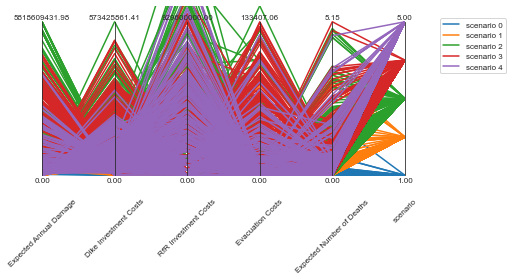

In [160]:
# limits.loc[0, ['inertia', 'reliability']] = 1
# limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
# limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
# limits.loc[1, :] = 0
colors = iter(sns.color_palette())

paraxes = parcoords.ParallelAxes(limits, fontsize=8, rot=45)


for i, result in enumerate(results):
    color = next(colors)
    data = result.iloc[:, -6:]
    paraxes.plot(data, label=f'scenario {i}', color=color)


paraxes.legend()
#plt.tight_layout(h_pad=0, w_pad=0)

plt.show()

In [209]:
import plotly.express as px
fig = px.parallel_coordinates(data, color='scenario')
fig.show()

In [162]:
data

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,scenario
0,5.065025e+06,1.680081e+08,176700000.0,0.000000,0.005419,5
1,2.089209e+07,1.573143e+08,30700000.0,0.000000,0.021499,5
2,4.742401e+05,2.928331e+08,0.0,29.955210,0.000159,5
3,7.042848e+06,1.596396e+08,334500000.0,0.000000,0.006798,5
4,5.808375e+07,1.296488e+08,61400000.0,1515.509535,0.007410,5
...,...,...,...,...,...,...
305,2.495090e+09,3.051883e+07,0.0,0.000000,2.559918,5
306,3.210067e+08,6.320800e+06,612100000.0,15738.851640,0.064921,5
307,3.288601e+08,6.947939e+07,61400000.0,0.000000,0.357315,5
308,9.757160e+08,7.332080e+06,333100000.0,25880.131367,0.636323,5


In [63]:
df12 = df1[['EWS_DaysToThreat', 'Evacuation Costs']]

In [128]:
type(paraxes)

ema_workbench.analysis.parcoords.ParallelAxes

In [98]:
opt2 = opt.loc[((opt['0_RfR 0']== 0 )&	(opt['0_RfR 1']== 0) &	(opt["0_RfR 2"]==0)),:]
opt2.sort_values(by=['Expected Number of Deaths'])

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
30,0,0,0,0,0,0,1,1,0,0,...,0,0,5,0,0,0.000000e+00,1.570805e+08,61400000.0,0.0,0.000000
883,0,0,0,0,0,0,1,1,0,1,...,0,3,9,0,0,0.000000e+00,2.275081e+08,303800000.0,0.0,0.000000
33,0,0,0,0,0,0,1,0,0,0,...,0,1,5,0,0,0.000000e+00,1.645576e+08,30700000.0,0.0,0.000000
1160,0,0,0,0,1,0,1,0,0,1,...,2,0,2,0,0,0.000000e+00,1.825784e+08,490900000.0,0.0,0.000000
73,0,0,0,0,0,0,1,1,1,0,...,0,0,6,0,0,0.000000e+00,9.226037e+07,213300000.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,0,0,0,0,0,0,0,0,0,0,...,0,5,0,0,0,4.429815e+09,3.136806e+07,0.0,0.0,4.855427
728,0,0,0,0,0,0,1,0,1,0,...,0,2,0,0,0,5.787176e+09,7.332080e+06,61400000.0,0.0,4.856800
656,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,5.793047e+09,2.662009e+07,30700000.0,0.0,4.868906
628,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,5.818609e+09,6.320800e+06,0.0,0.0,4.921618


In [82]:
for i, result in enumerate(results):
    print(result)

     0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0          1        0        0        0        0        0        1        1   
1          0        0        0        0        0        0        1        1   
2          0        0        0        0        0        0        1        0   
3          0        0        0        0        0        0        0        1   
4          0        0        0        0        0        0        0        0   
..       ...      ...      ...      ...      ...      ...      ...      ...   
195        1        1        1        0        0        0        1        1   
196        0        0        0        0        0        0        1        0   
197        0        0        0        0        0        0        1        0   
198        0        0        0        0        0        0        0        0   
199        0        1        0        0        0        0        0        0   

     2_RfR 2  3_RfR 0  ...  A.4_DikeIncrease 1  A.4

In [78]:
enumerate(results)

In [ ]:
# Define two functions to get the 5th and 95th quantiles
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

# Create a Pandas GroupBy object
group_df = df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create a dictionary with what outcome values are aggegrated with which functions
agg_dict = {
    "A.3 Total Costs": agg_par,
    "A.3_Expected Number of Deaths": agg_par,
    "RfR Total Costs": agg_par,
    "Expected Evacuation Costs": agg_par,
}
# Create new dataframe with the aggegrated data per policy
TCA_df = group_df.agg(agg_dict)
TCA_df

# Save the aggegrated data to a CSV file
TCA_df.to_csv("results/TCA3_results.csv")

# Create a Pandas GroupBy object
group_df = df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create a dictionary with what outcome values are aggegrated with which functions
agg_dict = {
    "A.2 Total Costs": agg_par,
    "A.2_Expected Number of Deaths": agg_par,
    "RfR Total Costs": agg_par,
    "Expected Evacuation Costs": agg_par,
}
# Create new dataframe with the aggegrated data per policy
TCA_df = group_df.agg(agg_dict)
TCA_df

In [ ]:
exp.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2', 'scenario', 'policy', 'model'],
      dtype='object')

In [ ]:
df

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,policy
0,2.501645e+09,1.729989,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,0.0,0.0,policy 1
1,0.000000e+00,0.000000,0.000000e+00,0.000000,1.539666e+09,3.266719,0.000000e+00,0.000000,0.000000e+00,0.00000,0.0,0.0,policy 1
2,5.818656e+08,0.323293,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,0.0,0.0,policy 1
3,3.261164e+09,1.721956,1.043510e+09,0.683729,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,0.0,0.0,policy 1
4,1.866160e+08,0.137513,1.242352e+07,0.012439,7.130209e+06,0.013678,3.568384e+07,0.017444,2.023429e+08,0.18995,0.0,0.0,policy 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.000000e+00,0.000000,2.478030e+07,0.027325,8.329663e+08,1.622513,0.000000e+00,0.000000,0.000000e+00,0.00000,30700000.0,0.0,policy 12
11996,2.860284e+09,1.763122,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,30700000.0,0.0,policy 12
11997,2.532460e+09,1.756891,0.000000e+00,0.000000,0.000000e+00,0.000000,3.321513e+06,0.001602,0.000000e+00,0.00000,30700000.0,0.0,policy 12
11998,0.000000e+00,0.000000,6.078269e+07,0.070693,0.000000e+00,0.000000,4.475099e+07,0.025756,0.000000e+00,0.00000,30700000.0,0.0,policy 12


In [ ]:
group_df = df.groupby(by="policy").mean()


In [ ]:
group_df

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
policy,,,,,,,,,,,,
policy 1,1.039204e+09,0.704187,1.370644e+08,0.122463,3.865438e+08,0.678590,1.670620e+07,0.007354,6.098912e+07,0.054641,0.0,0.0
policy 10,1.039204e+09,0.704187,1.051352e+08,0.092625,2.182347e+08,0.373111,1.989694e+07,0.008875,7.485589e+07,0.067451,30700000.0,0.0
policy 11,1.039204e+09,0.704187,1.051352e+08,0.092625,2.182347e+08,0.373111,1.989694e+07,0.008875,7.485589e+07,0.067451,30700000.0,0.0
policy 12,1.039204e+09,0.704187,1.051352e+08,0.092625,2.182347e+08,0.373111,1.989694e+07,0.008875,7.485589e+07,0.067451,30700000.0,0.0
policy 2,1.039204e+09,0.704187,1.370644e+08,0.122463,4.754776e+07,0.033791,2.130241e+07,0.009570,8.326142e+07,0.075155,0.0,0.0
policy 3,1.039204e+09,0.704187,1.370644e+08,0.122463,4.431904e+07,0.000210,2.157276e+07,0.009706,8.513519e+07,0.076859,0.0,0.0
policy 4,3.909440e+08,0.257598,1.659594e+08,0.149220,4.594375e+08,0.806344,2.199551e+07,0.009738,7.880140e+07,0.070231,84600000.0,0.0
policy 5,3.909440e+08,0.257598,1.659594e+08,0.149220,4.594375e+08,0.806344,2.199551e+07,0.009738,7.880140e+07,0.070231,84600000.0,0.0
policy 6,3.909440e+08,0.257598,1.659594e+08,0.149220,4.594375e+08,0.806344,2.199551e+07,0.009738,7.880140e+07,0.070231,84600000.0,0.0


In [ ]:
out = pd.DataFrame(out)

In [ ]:
# set up PRIM

# uncertainties
x_prim = exp[['discount rate 0', 'discount rate 1', 'discount rate 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate', 'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail', 'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax', 'A.5_pfail', 'A.5_Brate']]

numdeaths = out[['A.1_Expected Number of Deaths','A.2_Expected Number of Deaths','A.3_Expected Number of Deaths','A.4_Expected Number of Deaths','A.5_Expected Number of Deaths']]
numdeaths["summed"] = numdeaths.sum(axis = 1, skipna = True)
sumcosts = out[['A.1 Total Costs','A.2 Total Costs','A.3 Total Costs','A.4 Total Costs','A.5 Total Costs']]
sumcosts["summed"] = sumcosts.sum(axis = 1, skipna = True)

# outcomes of interest -> bad outcomes
#y = data < np.percentile(data, 10)

y_prim = ((out['A.3_Expected Number of Deaths'] > 0) | (numdeaths["summed"]>1))

C:\Users\hanna\AppData\Local\Temp\ipykernel_9340\2838103952.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numdeaths["summed"] = numdeaths.sum(axis = 1, skipna = True)
C:\Users\hanna\AppData\Local\Temp\ipykernel_9340\2838103952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sumcosts["summed"] = sumcosts.sum(axis = 1, skipna = True)


In [ ]:
sum(y_prim)

8314

In [ ]:
y_prim

0         True
1         True
2        False
3         True
4         True
         ...  
11995     True
11996     True
11997     True
11998    False
11999     True
Length: 12000, dtype: bool

In [ ]:
out

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,2.501645e+09,1.729989,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,0.0,0.0
1,0.000000e+00,0.000000,0.000000e+00,0.000000,1.539666e+09,3.266719,0.000000e+00,0.000000,0.000000e+00,0.00000,0.0,0.0
2,5.818656e+08,0.323293,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,0.0,0.0
3,3.261164e+09,1.721956,1.043510e+09,0.683729,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,0.0,0.0
4,1.866160e+08,0.137513,1.242352e+07,0.012439,7.130209e+06,0.013678,3.568384e+07,0.017444,2.023429e+08,0.18995,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.000000e+00,0.000000,2.478030e+07,0.027325,8.329663e+08,1.622513,0.000000e+00,0.000000,0.000000e+00,0.00000,30700000.0,0.0
11996,2.860284e+09,1.763122,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,30700000.0,0.0
11997,2.532460e+09,1.756891,0.000000e+00,0.000000,0.000000e+00,0.000000,3.321513e+06,0.001602,0.000000e+00,0.00000,30700000.0,0.0
11998,0.000000e+00,0.000000,6.078269e+07,0.070693,0.000000e+00,0.000000,4.475099e+07,0.025756,0.000000e+00,0.00000,30700000.0,0.0


In [ ]:
from ema_workbench.analysis import prim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


prim_alg = prim.Prim(x_prim,y_prim, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 12000 points remaining, containing 8314 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.121, coverage: 0.17464517681019967, density: 1.0 restricted_dimensions: 4


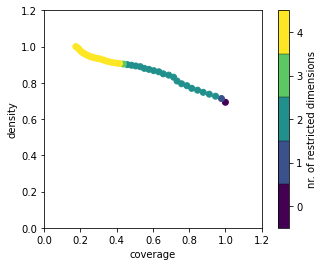

In [ ]:
# show tradeoff
box1.show_tradeoff()
plt.show()

coverage    0.713976
density     0.831373
id                10
mass           0.595
mean        0.831373
res_dim            2
Name: 10, dtype: object

             box 10                                          
                min       max                       qp values
A.3_pfail  0.000827  0.735273  [-1.0, 1.7782946925949596e-82]
A.2_pfail  0.184952  0.999621  [3.1300625645325037e-30, -1.0]



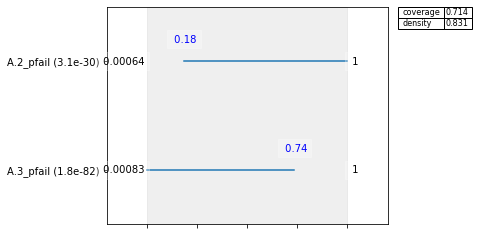

In [ ]:
# inspect box
box_n = 10
box1.inspect(box_n)
box1.inspect(box_n, style='graph')
plt.show()

In [ ]:
# get scenarios and outcomes with selected box
scenarios = x_prim.iloc[box1.yi]
outcome = {k:v[box1.yi] for k,v in out.items()}

In [ ]:
scenarios = scenarios.drop_duplicates()
scenarios

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,A.3_Bmax,A.3_pfail,A.3_Brate,A.4_Bmax,A.4_pfail,A.4_Brate,A.5_Bmax,A.5_pfail,A.5_Brate
11,4.5,2.5,2.5,25.0,225.981598,0.248290,10,134.792382,0.745622,10,79.284793,0.084387,10,265.738330,0.802810,10,60.622234,0.591549,1.0
29,3.5,4.5,4.5,57.0,250.814879,0.148302,10,284.920002,0.603536,1.5,67.684391,0.336104,1.5,225.222331,0.174397,1.0,121.604194,0.837067,1.0
31,1.5,2.5,3.5,45.0,141.614379,0.063440,1.0,178.672063,0.611681,1.5,341.105563,0.025371,10,205.206968,0.888077,10,160.271812,0.209182,1.5
34,2.5,1.5,1.5,80.0,116.742047,0.039622,1.0,95.233189,0.780582,1.0,213.758939,0.130030,10,139.306593,0.929521,1.0,152.880617,0.967515,1.5
38,4.5,4.5,3.5,132.0,232.445006,0.006406,1.5,82.350020,0.387341,1.5,100.100898,0.059945,1.0,336.765686,0.300191,1.0,222.754015,0.331822,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,4.5,1.5,1.5,90.0,172.160258,0.273019,1.0,240.184137,0.442756,1.0,220.631782,0.327340,1.5,49.770997,0.741815,10,278.019125,0.863126,10
967,2.5,3.5,2.5,33.0,75.573249,0.336877,1.5,108.976358,0.392879,10,341.916912,0.391249,1.5,85.019400,0.435894,1.0,318.798098,0.800413,10
969,1.5,4.5,4.5,40.0,335.086732,0.067665,1.5,46.739259,0.530109,10,115.467523,0.172743,10,45.821441,0.635878,10,131.368245,0.564072,1.0
974,4.5,4.5,3.5,57.0,277.910332,0.191499,1.0,46.568675,0.234584,10,43.552448,0.292609,1.5,150.615411,0.745120,1.0,313.964417,0.531684,1.0


In [ ]:
# save scenarios
scenarios_dict = scenarios.to_dict(orient = 'records')
scenarios_w = []

for s in range(len(scenarios_dict)):
    scenarios_w.append(Scenario(str(s), **scenarios_dict[s]))

import pickle

with open('./PRIM_scenarios.txt', 'wb') as file:
    pickle.dump(scenarios_w, file)


In [ ]:
data

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,2.501645e+09,1.729989,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0
1,0.000000e+00,0.000000,0.000000e+00,0.000000,1.539666e+09,3.266719,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0
3,3.261164e+09,1.721956,1.043510e+09,0.683729,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0
4,1.866160e+08,0.137513,1.242352e+07,0.012439,7.130209e+06,0.013678,3.568384e+07,0.017444,2.023429e+08,0.189950,0.0,0.0
5,0.000000e+00,0.000000,1.844479e+07,0.015652,1.713451e+08,0.270652,4.950700e+07,0.020221,0.000000e+00,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11994,1.770655e+09,1.223418,1.039194e+08,0.096551,0.000000e+00,0.000000,1.521719e+07,0.007171,6.282735e+07,0.057552,30700000.0,0.0
11995,0.000000e+00,0.000000,2.478030e+07,0.027325,8.329663e+08,1.622513,0.000000e+00,0.000000,0.000000e+00,0.000000,30700000.0,0.0
11996,2.860284e+09,1.763122,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,30700000.0,0.0
11997,2.532460e+09,1.756891,0.000000e+00,0.000000,0.000000e+00,0.000000,3.321513e+06,0.001602,0.000000e+00,0.000000,30700000.0,0.0


In [ ]:
from ema_workbench.analysis import dimensional_stacking

In [ ]:
y_prim

0         True
1         True
2        False
3         True
4         True
         ...  
11995     True
11996     True
11997     True
11998    False
11999     True
Length: 12000, dtype: bool

c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:423: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


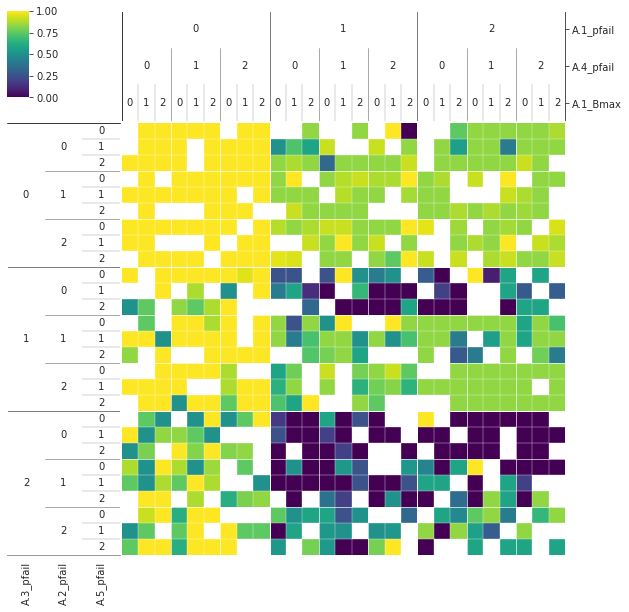

In [ ]:
dimensional_stacking.create_pivot_plot(x_prim, y_prim)
plt.show()

In [ ]:
import pickle

with open('./PRIM_scenarios.txt', 'wb') as file:
    pickle.dump(scenarios_w, file)